# 사운드 프로세싱 기초
1. 소리는 공기를 구성하는 입자들이 진동하는 현상
2. 공기의 진동을 측정하는 양적 기준을 음압(sound pressure) 이라고 함
3. 사운드 데이터란, 이 음압의 변화를 기록한 시계열 데이터

# 오디오 처리(Audio Processing)

* 소리 및 음악과 관련된 신호를 분석, 처리, 생성하는 작업

* 소리는 진동으로 인한 공기의 압축으로 생성
* 압축이 얼마나 됬느냐에 따라 진동하며, 공간이나 매질을 전파해 나가는 현상인 Wave(파동)으로 표현
* 파동에서 얻을 수 있는 정보
  + 위상(Phase; Degrees of displacement) : 반복되는 파형의 한 주기에서 첫 시작점의 각도 혹은 어느 한 순간의 위치
  + 진폭(Amplitude; Intensity)
  + 주파수(Frequency)

![](https://miro.medium.com/max/700/0*QFVha2lCgyhKjhuO.gif)

## 오디오 라이브러리

* librosa는 각종 음성 처리에 유용한 라이브러리
* colab 환경에서 torchaudio는 별도 설치가 필요
* 해당 예제에서는 torchaudio를 이용해 음성 데이터를 가져옴

In [98]:
!pip install torchaudio

Defaulting to user installation because normal site-packages is not writeable


In [46]:
!pip install librosa


Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 253.7/253.7 kB 7.9 MB/s eta 0:00:00
     -------------------------------------- 184.8/184.8 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 10.6 MB/s eta 0:00:00
     ---------------------------------------- 62.7/62.7 kB 3.3 MB/s eta 0:00:00


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display
import torch
import torchaudio
import IPython.display as ipd

## 오디오 데이터 

*   pytorch의 torchaudio를 사용해 내장 데이터셋을 가져옴
*   데이터가 크기 때문에 시간이 많이 소요

In [49]:
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

100%|██████████| 5.95G/5.95G [19:56<00:00, 5.34MB/s]   
100%|██████████| 331M/331M [01:33<00:00, 3.71MB/s]   


*   불러온 데이터 확인
  *   첫번째 줄에서는 소리 데이터 확인 가능
  *   두번째 줄에선 해당 데이터의 sampling rate 확인 가능

In [50]:
test_dataset[1]   # tensor 구조 , 각종 정보들

(tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]]),
 16000,
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 1089,
 134686,
 1)

*   불러온 데이터의 형상을 확인
*   데이터 길이만으로는 음성이 몇초에 해당하는지(duration)를 알 수 없음

In [52]:
test_dataset[1][0].shape

torch.Size([1, 52400])

## 샘플링(Sampling)

### Sampling

* 음성을 처리하기 위해 아날로그 정보를 잘게 쪼개 이산적인 디지털 정보로 표현해야 함
* 이때 무한히 쪼개서 저장할 수는 없으므로, 기준을 세워 아날로그 정보를 쪼개 대표값을 사용, 이를 샘플링이라 함
* 주로 사용할 때 시간을 기준으로 아날로그 정보를 쪼개는 Time Domain 방식을 사용

* Sampling rate
  * sampling rate는 아날로그 정보를 얼마나 잘게 쪼갤지를 결정
  * 잘게 쪼갤수록 정보 손실이 줄어들지만, 데이터의 크기가 늘어남
* Sampling theorem
  * sampling rate가 최대 frequency보다 2배 커져야 함을 의미
  * 일반적으로 sampling은 인간의 청각 영역에 맞게 형성
    - Audio CD : 44.1 kHz(44100 sample/second)
    - Speech communication : 8 kHz(8000 sample/second)

*   음성의 duration은 데이터의 길이와 sampling rate를 나누어 확인 가능

In [57]:
audio_data = test_dataset[1][0][0]
sr = test_dataset[1][1]

print(audio_data, sr)
print('length:', len(audio_data))
print('duration:', len(audio_data) / sr)

ipd.Audio(audio_data, rate=sr)

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) 16000
length: 52400
duration: 3.275


### Normalization & Quantization

1.   항목 추가
2.   항목 추가

*   데이터간 음량이 제각각인 경우 normalization을 하여 amplitude를 [-1, 1] 범위로 조정
*   여기서는 가장 간단한 방법인 데이터의 최대값으로 나눠주는 방법을 사용

In [127]:
audio_np = audio_data.numpy()
normed_wav = audio_np / max(np.abs(audio_np))  # 정규화는 일반적으로 오디오 신호의 크기를 일정한 범위로 맞추어주는 과정 - 최대 절댓값으로 나누어 정규화된 오디오를 생성
ipd.Audio(normed_wav, rate=sr)  # rate=sr 샘플링 속도를 나타냄

In [87]:
bit = 8
max_value = 2 ** (bit-1)          # 노이즈 심해짐

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1)
ipd.Audio(quantized_8_wav, rate=sr)

### Mu-Law Encoding

* 사람의 귀는 작은소리의 차이는 잘잡아내는데 반해 소리가 커질수록 그 차이를 잘 느끼지 못함
* 이러한 특성을 wave값을 표현하는데 반영해 작은 값에는 높은 분별력을, 큰 값끼리는 낮은 분별력을 갖도록 함

In [88]:
def mu_law(x, mu=255):
    return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

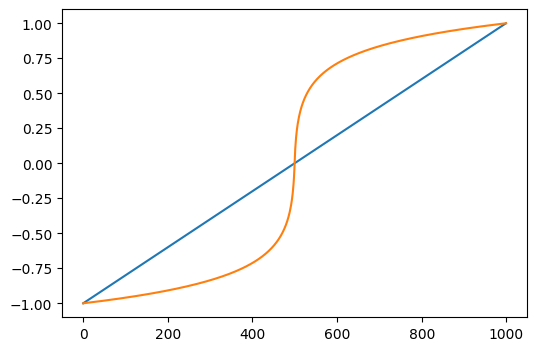

In [89]:
x = np.linspace(-1, 1, 1000)
x_mu = mu_law(x)

plt.figure(figsize=[6,4])
plt.plot(x)
plt.plot(x_mu)
plt.show()

In [91]:
wav_mulaw = mu_law(normed_wav)   # nomalized 랑 Mu 의 차이
ipd.Audio(wav_mulaw, rate=sr)

# 오디오 표현(Audio Representation)

* Sampling된 discrete한 데이터를 표현
  + 시간의 흐름에 따라, 공기의 파동의 크기로 보는 Time-Domain Representation 방법
  + 시간에 따라서 frequency의 변화를 보는 Time-Frequency Representation

## 사인 함수
- 음압의 변화를 나타내는 시계열 데이터 중 가장 단순한 형태가 사인 함수(sine function)이다. 
- 삼각함수 중 하나인 사인 함수의 특징 3가지
1. 진폭(amplitude) A: 위 아래로 움직이는 폭. (=소리의 크기로 인식)
2. 주파수(frequency) w 또는 f: 진동 속도. 주파수가 높으면 빠르게 진동. (=소리의 높낮이로 인식) - 초당 진동횟수
3. 위상(phase) : 사인 함수의 시작지점. 위상만큼 출발이 늦어진다. (위상의 차이 = 소리의 시간차로 인식)

Font 'default' does not have a glyph for '\uc8fc' [U+c8fc], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ud30c' [U+d30c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uc218' [U+c218], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uc9c4' [U+c9c4], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ud3ed' [U+d3ed], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uc704' [U+c704], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uc0c1' [U+c0c1], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uc9c4' [U+c9c4], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ud3ed' [U+d3ed], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uc774' [U+c774], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ub85c' [U+b85c], 

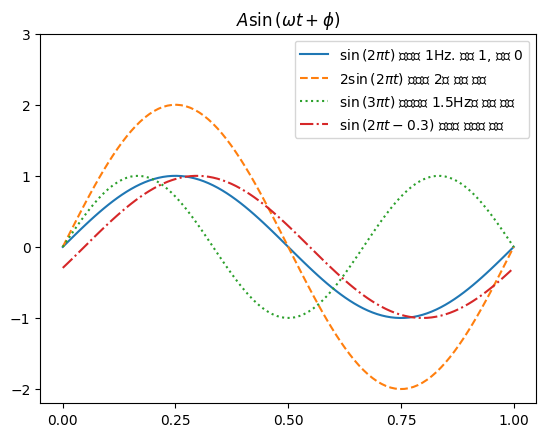

In [10]:
t = np.linspace(0, 1, 100)

plt.plot(t, 1 * np.sin(2 * np.pi * t + 0), ls="-", label=r"$\sin\left(2\pi{t}\right)$ 주파수 1Hz. 진폭 1, 위상 0")
plt.plot(t, 2 * np.sin(2 * np.pi * t + 0), ls="--", label=r"$2\sin\left(2\pi{t}\right)$ 진폭이 2로 커진 경우 ")
plt.plot(t, 1 * np.sin(3 * np.pi * t + 0), ls=":", label=r"$\sin\left(3\pi{t}\right)$ 주파수가 1.5Hz로 커진 경우")
plt.plot(t, 1 * np.sin(2 * np.pi * t - 0.3), ls="-.", label=r"$\sin\left(2\pi{t} - 0.3\right)$ 위상이 늦춰진 경우")
plt.ylim(-2.2, 3)
plt.xticks(np.linspace(0, 1, 5))
plt.legend()
plt.title(r"$A\sin\left(\omega{t}+\phi\right)$")
plt.show()

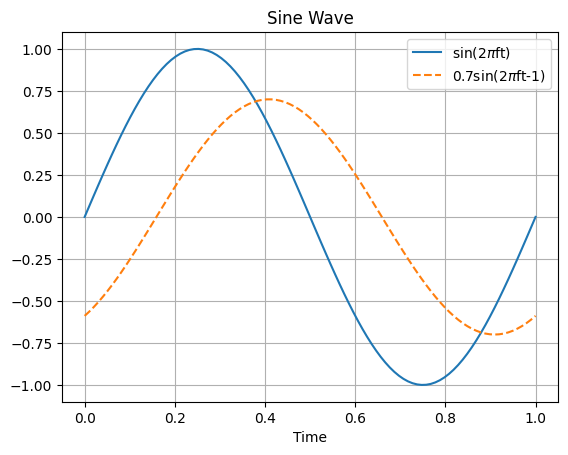

In [116]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0,1,100)
f = 1 #1Hz

plt.plot(t, 1 * np.sin(2*np.pi*f*t + 0), "-", 
         label='sin(2$\pi$ft)')
plt.plot(t, 0.7 * np.sin(2*np.pi*f*t - 1), ls="--", 
         label='0.7sin(2$\pi$ft-1)')

plt.xlabel("Time")
plt.title("Sine Wave")
plt.legend();plt.grid();plt.show()

In [128]:
from IPython.display import Audio, display

display(Audio(y, rate=44100))

# 싱글 톤
* 주파수는 사람에게 음의 높이(tone)으로 인식
* 사인파처럼 주파수가 일정한 음압 시계열은 사람에게 음높이가 일정한 "삐-"하는 기계음으로 들리기 때문에 하나의 사인파로 이루어진 소리를 싱글 톤(single tone)이라고 함
* 전화를 걸 때 수신자가 전화를 받기 전까지 재생되는 통화연결음(ring tone)은 보통 400Hz~450Hz의 싱글톤을 사용

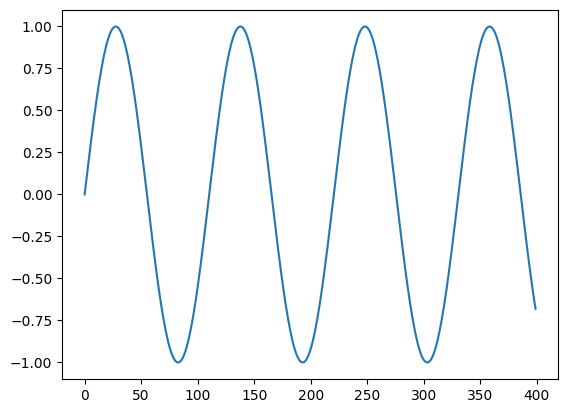

In [11]:
def single_tone(frequecy, sampling_rate=44100, duration=1):
    # frequency: 주파수
    # sampling_rate: 초당 샘플링 데이터 수. 디폴트 44100
    # duration: 지속 시간. 단위 초. 디폴트 1초
    t = np.linspace(0, duration, int(sampling_rate))
    y = np.sin(2 * np.pi * frequecy * t)
    return y

y = single_tone(400)

plt.plot(y[:400])
plt.show()

* 주피터 노트북에서는 다음 코드로 사운드 데이터를 표시할 수 있음

In [12]:
from IPython.display import Audio, display

display(Audio(y, rate=44100))

In [13]:
notes = 'C,C#,D,D#,E,F,F#,G,G#,A,A#,B,C'.split(',')
freqs = 261.62 * 2**(np.arange(0, len(notes)) / 12.)
notes = list(zip(notes, freqs))
notes

[('C', 261.62),
 ('C#', 277.17673474627884),
 ('D', 293.6585210786982),
 ('D#', 311.1203654270119),
 ('E', 329.6205450734967),
 ('F', 349.2208026479644),
 ('F#', 369.98655218804913),
 ('G', 391.9870974524774),
 ('G#', 415.29586321592035),
 ('A', 439.9906403173536),
 ('A#', 466.1538452797511),
 ('B', 493.8727953675693),
 ('C', 523.24)]

In [129]:
octave = np.hstack([single_tone(f) for f in freqs])
display(Audio(octave, rate=44100))

* 복수의 싱글톤을 더하여 한번에 소리를 내면 화음이 됨.
* 예를 들어 도(C) 미(E) 솔(G) 3도 화음은 다음과 같다.

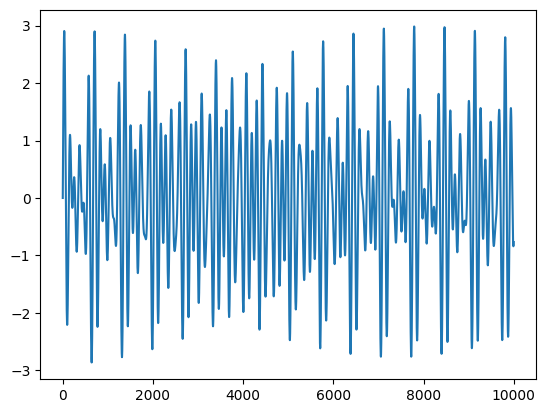

In [131]:
tone_C = single_tone(261.62)  # 주파수가 261.62Hz
tone_E = single_tone(329.62)  # 주파수가 329.62Hz
tone_G = single_tone(392)     
harmony = tone_C + tone_E + tone_G

plt.plot(harmony[:10000])  # 데이터 처음부터 10,000번째 인덱스까지의 부분을 선택하여 시각화
plt.show()

In [132]:
display(Audio(harmony, rate=44100))  # Harmony 오디오 데이터를 44,100Hz 샘플링 속도로 재생됨 - 1초당 44,100샘플이 재생

## Wave 형식 파일


* wave 파일은 음압 시계열 데이터를 저장하는 가장 기본적인 파일 형식으로 .wav 확장자로 표시한다.
* 파이썬에서 wave 파일을 쓰거나 읽기 위해서는 scipy 패키지의 io.wavfile 서브패키지에서 제공하는 read, write 명령을 사용한다.

In [24]:
pip install scipy.io.wavfile

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scipy.io.wavfile (from versions: none)
ERROR: No matching distribution found for scipy.io.wavfile


In [102]:
pip install scipy.io.wavfile

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement scipy.io.wavfile (from versions: none)
ERROR: No matching distribution found for scipy.io.wavfile


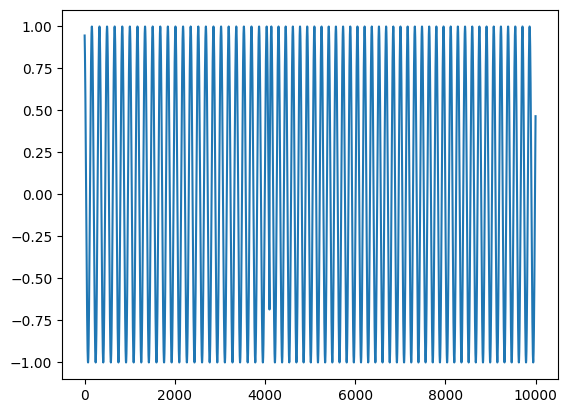

In [133]:
import scipy.io.wavfile as sp

# 초당 샘플링 데이터 수 
sampling_rate = 44100
scipy.io.wavfile.write("octave.wav", sampling_rate, octave)  #주파수가 261.62Hz인 음향 톤 데이터인 octave를 "octave.wav" 파일로 저장. 샘플링 속도는 sampling_rate로 설정

sr, y_read = scipy.io.wavfile.read("octave.wav")  # 오디오 데이터 저장
# sr == sampling_rate

plt.plot(y_read[40000:50000])  # y_read에서 40,000번째 샘플부터 50,000번째 샘플까지의 부분을 선 그래프로 시각화
plt.show()

In [105]:
Audio(y_read, rate=sr)

## Dual-tone multi-frequency signaling

In [ ]:
# 연습문제1
# DTMF를 사용하여 자신의 전화번호를 호출하는 음향신호를 생성하라.

# 푸리에 변환과 스펙트럼

* 음성(speech), 음악(music) 등의 음향(sound) 데이터에서 특징(feature)을 추출하는 방법인 푸리에 변환(Fourier transform)과 스펙트럼(spectrum) 에 대해 알아본다.

## 푸리에 변환(Fourier Transform, FT)

* 시간이나 공간에 대한 함수를 시간 또는 공간 주파수 성분으로 분해하는 변환
* 이 변환으로 나타난 주파수 영역에서 함수를 표현한 결과물을 가리키는 용어로도 종종 사용

## 정현파 조합

* 여러 개의 정현파(sin 또는 cos함수)를 합성하여 하나의 복합 파형을 만들어내는 과정

* 모든 신호는 주파수(frequency)와 크기(magnitude), 위상(phase)이 다른 정현파(sinusolida signal)의 조합으로 나타낼 수 있다.
* 퓨리에 변환은 조합된 정현파의 합(하모니)신호에서 그 신호를 구성하는 정현파들을 각각 분리해내는 방법이다.

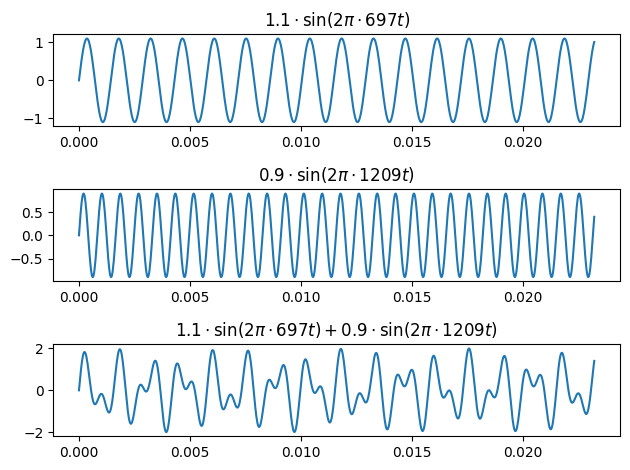

In [139]:
# 파라미터 설정
N = 1024   # 생성할 파형의 샘플 수 (크기)
T = 1.0 / 44100.0  # 샘플간의 시간 간격, 즉 샘플링의 주기
f1 = 697    # 첫번째 정현파의 주파수
f2 = 1209   # 두번째 정현파의 주파수
t = np.linspace(0.0, N*T, N)   # 0부터 N*T까지의 범위에서 등간격으로 'N'개의 샘플을 생성하여 시간 배열 't'를 만듦

# 정현파 생성
y1 = 1.1 * np.sin(2 * np.pi * f1 * t)  #첫 번째 정현파 생성. 주파수 f1을 갖는 sin 함수를 시간 배열 t에 대해 계산하고 진폭을 1.1로 조절
y2 = 0.9 * np.sin(2 * np.pi * f2 * t)
y = y1 + y2

# 시각화
plt.subplot(311)
plt.plot(t, y1)
plt.title(r"$1.1\cdot\sin(2\pi\cdot 697t)$")
plt.subplot(312)
plt.plot(t, y2)
plt.title(r"$0.9\cdot\sin(2\pi\cdot 1209t)$")
plt.subplot(313)
plt.plot(t, y)
plt.title(r"$1.1\cdot\sin(2\pi\cdot 697t) + 0.9\cdot\sin(2\pi\cdot 1209t)$")
plt.tight_layout()
plt.show()

## 고속 퓨리에 변환

* 고속 퓨리에 변환(Fast Fourier Transform, FFT)는 아주 적은 계산량으로 DFT를 하는 알고리즘을 말한다.
* 길이가 2의 n제곱인 시계열에만 적용할 수 있다는 단점이 있지만, 보통의 DFT가 --------------------
* 실제로는 다음과 같이 계속 반복되는 시계열에 대해 푸리에 변환을 하는 것이다.
* 따라서 시계열의 시작 부분과 끝 부분이 너무 다르면 원래 시계열에는 없는 신호가 나올 수도 있는데, 이를 깁스 현상(Gibbs phenomenon)이라고 한다.

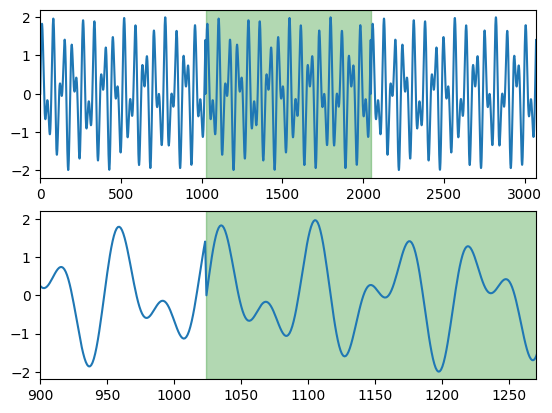

In [31]:
y2 = np.hstack([y, y, y])

plt.subplot(211)
plt.plot(y2)
plt.axvspan(N, N * 2, alpha=0.3, color='green')
plt.xlim(0, 3 * N)

plt.subplot(212)
plt.plot(y2)
plt.axvspan(N, N * 2, alpha=0.3, color='green')
plt.xlim(900, 1270)

plt.show()

* scipy 패키지의 fftpack 서브패키지에서 제공하는 fft명령으로 이 신호에 담겨진 주파수를 분석하면 다음과 같이 692Hz와 1211Hz 성분이 강하게 나타나는 것을 볼 수 있다.
* 이와 같은 플롯을 피리오도그램(periodogram)이라고 한다.

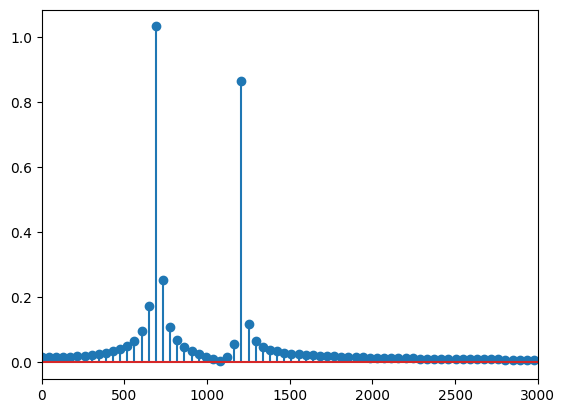

In [32]:
from scipy.fftpack import fft

yf = fft(y, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.stem(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim(0, 3000)

plt.show()

## DCT

* DCT(Discrete Cosine Transform)는 DFT와 유사하지만 기저함수로 복소 지수함수가 아닌 코사인 함수를 사용한다.
* DFT보다 계산이 간단하고 실수만 출력한다는 장점이 있어서 DFT 대용으로 많이 사용된다.

C:\Users\강세영\AppData\Local\Temp\ipykernel_7632\2250906372.py:18: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  plt.tight_layout()
C:\Users\강세영\AppData\Local\Temp\ipykernel_7632\2250906372.py:18: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
C:\Users\강세영\AppData\Local\Temp\ipykernel_7632\2250906372.py:18: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  plt.tight_layout()
C:\Users\강세영\AppData\Local\Temp\ipykernel_7632\2250906372.py:18: UserWarning: Glyph 54728 (\N{HANGUL SYLLABLE HEO}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.

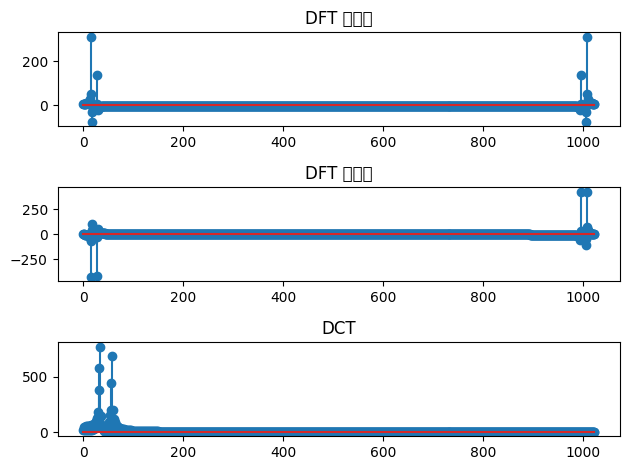

In [33]:
from scipy.fftpack import dct

dct_type = 2
yf2 = dct(y, dct_type, N)

plt.subplot(311)
plt.stem(np.real(yf))
plt.title("DFT 실수부")

plt.subplot(312)
plt.stem(np.imag(yf))
plt.title("DFT 허수부")

plt.subplot(313)
plt.stem(np.abs(yf2))
plt.title("DCT")

plt.tight_layout()
plt.show()

## 스펙트럼

* 보통 스펙트럼(spectrum)이라고 부르는 시계열 분석의 정확한 명칭은 파워 스펙트럼(power spectrum) 또는 스펙트럼 밀도(spectrum density)이다.
* 푸리에 변환은 결정론적인 시계열 데이터를 주파수 영역으로 변환하는 것을 말하지만, 스펙트럼(spectrum)은 확률론적인 확률과정(random process)모형을 주파수 영역으로 변환하는 것을 말한다.
* 따라서, 푸리에 변환과 달리 시계열의 위상(phase)정보는 스펙트럼에 나타나지 않는다.
* 스펙트럼을 추정할 때 사용하는 방법 중의 하나 전체 시계열을 짧은 구간으로 나눈 뒤 깁스 현상을 줄이기 위해 각 구간에 윈도우를 씌우고 FFT 계산으로 나온 값을 평균하는 방법이다.
* 보통은 로그 스케일로 표현한다.

C:\Users\강세영\AppData\Local\Temp\ipykernel_7632\3388103022.py:16: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from current font.
  plt.tight_layout()
C:\Users\강세영\AppData\Local\Temp\ipykernel_7632\3388103022.py:16: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  plt.tight_layout()
C:\Users\강세영\AppData\Local\Temp\ipykernel_7632\3388103022.py:16: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  plt.tight_layout()
C:\Users\강세영\AppData\Local\Temp\ipykernel_7632\3388103022.py:16: UserWarning: Glyph 52992 (\N{HANGUL SYLLABLE KE}) missing from current font.
  plt.tight_layout()
C:\Users\강세영\AppData\Local\Temp\ipykernel_7632\3388103022.py:16: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
C:\Users\강세영\AppData\Local\Temp\ipykernel_7632\3388103022.py:16: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from current font.
  plt.tight_layout()
C:\Users\강세영\Ap

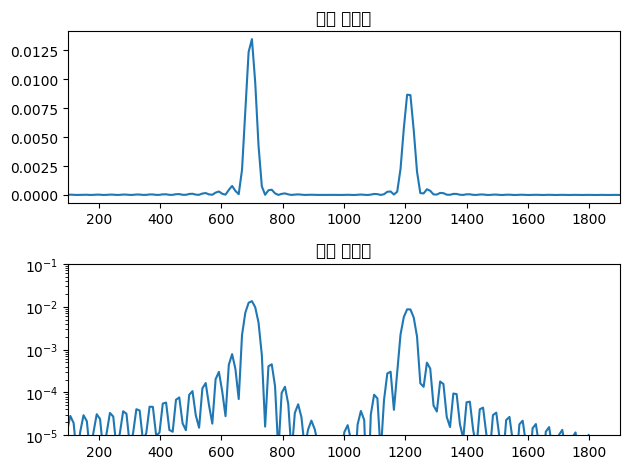

In [108]:
import scipy.signal

f, P = scipy.signal.periodogram(y, 44100, nfft=2**12)

plt.subplot(211)
plt.plot(f, P)
plt.xlim(100, 1900)
plt.title("선형 스케일")

plt.subplot(212)
plt.semilogy(f, P)
plt.xlim(100, 1900)
plt.ylim(1e-5, 1e-1)
plt.title("로그 스케일")

plt.tight_layout()
plt.show()

## librosa 패키지

* 파이썬으로 STFT 스펙트럼 분석을 하려면 librosa 패키지를 사용한다.

* 주피터 노트북에서 librosa 패키지를 사용할 때는 jupyter_notebook_config.py파일의 iopub_data_rate_limit 설정을 10000000 정도로 크게 해야 한다.

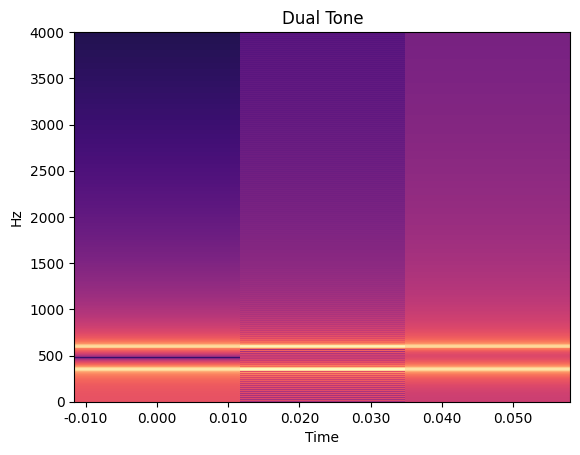

In [141]:
import librosa
import librosa.display

#Short-Time Fourier Transform (STFT) - 시간 영역에서 신호의 주파수 특성을 분석하기 위한 변환 기법, 시간에 따른 주파수 변화를 살펴보는 데 사용됨 
D = np.abs(librosa.stft(y))  # librosa.stft(y): 입력으로 받은 음성 신호 y에 대해 Short-Time Fourier Transform (STFT)을 수행하여 주파수-시간 표현을 얻음 
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear', x_axis='time')  # 주파수-시간 표현의 강도를 데시벨로 변환. 이는 주로 로그 스케일로 변환하여 음성 신호의 다이나믹 레인지를 더 잘 시각화하기 위한 것
plt.title('Dual Tone')  # y축은 선형 스케일로, x축은 시간으로 설정
plt.ylim(0, 4000)
plt.show()

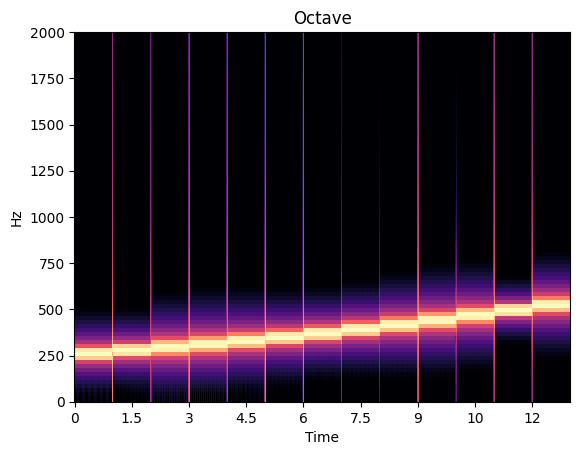

In [142]:
sr_octave, y_octave = scipy.io.wavfile.read("octave.wav")

D_octave = np.abs(librosa.stft(y_octave))
librosa.display.specshow(librosa.amplitude_to_db(D_octave, ref=np.max), sr=sr_octave, y_axis='linear', x_axis='time')
plt.title('Octave')
plt.ylim(0, 2000)
plt.show()

## 멜 스펙트럼

* 멜 스펙트럼은 주파수의 단위를 다음 공식을 따라 멜 단위(mel unit)로 바꾼 스펙트럼을 말한다.

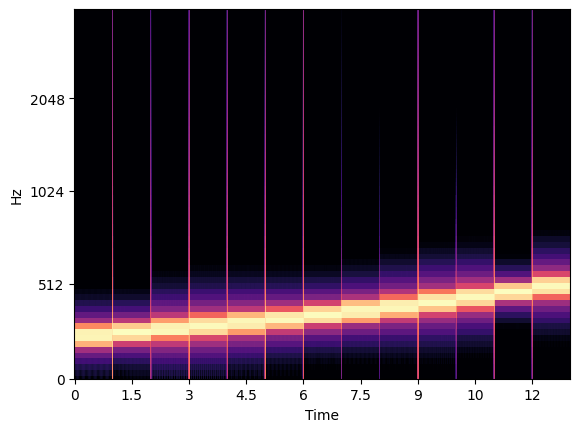

In [112]:
S_octave = librosa.feature.melspectrogram(y=y_octave, sr=sr_octave, n_mels=128)
librosa.display.specshow(librosa.power_to_db(S_octave, ref=np.max), sr=sr_octave, y_axis='mel', x_axis='time')
plt.ylim(0, 4000)
plt.show()

## MFCC

* MFCC(Mel-frequency cepstral coefficients)는 Mel Scale Spectrum을 40개의 주파수 구역(band)으로 묶은 뒤에 이를 다시 푸리에 변환하여 얻은 계수이다.
* 스펙트럼이 어떤 모양으로 되어있는지를 나타내는 특성 값

In [114]:
y, sr = librosa.load(librosa.util.example_audio_file(), offset=30, duration=5)

plt.plot(y[1000:5000])
plt.show()

AttributeError: No librosa.util attribute example_audio_file

In [39]:
from IPython.display import Audio, display
Audio(y, rate=sr)

NameError: name 'sr' is not defined

In [ ]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, y_axis='mel', x_axis='time')
plt.show()

In [ ]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis='time')
plt.title('MFCC')
plt.tight_layout()
plt.show()